# Creating ML Model for 311 Analysis

## Import Packages and Data

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import pickle

In [3]:
requests_21 = pd.read_csv('../data/2021_closed_requests.csv', low_memory=False)
requests_22 = pd.read_csv('../data/2022_closed_requests.csv', low_memory=False)

## Data Exploration

### Investigate number of data points

In [4]:
print("Shape of 2021 data:", requests_21.shape)
print("Shape of 2022 data:", requests_22.shape)

Shape of 2021 data: (359090, 23)
Shape of 2022 data: (348924, 23)


### Check for null values in all columns
- 2021

In [5]:
requests_21.isna().sum()

service_request_id                0
service_request_parent_id    320300
sap_notification_number      312452
date_requested                    0
case_age_days                     8
case_record_type                  0
service_name                      0
service_name_detail          110504
date_closed                       8
status                            0
lat                            2609
lng                            2609
street_address                  534
zipcode                      125914
council_district               2925
comm_plan_code                 2984
comm_plan_name                 2984
park_name                    340158
case_origin                      34
referred                     297104
iamfloc                      166284
floc                         166145
public_description            25982
dtype: int64

### Explore each Column

In [6]:
requests_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359090 entries, 0 to 359089
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   service_request_id         359090 non-null  int64  
 1   service_request_parent_id  38790 non-null   float64
 2   sap_notification_number    46638 non-null   float64
 3   date_requested             359090 non-null  object 
 4   case_age_days              359082 non-null  float64
 5   case_record_type           359090 non-null  object 
 6   service_name               359090 non-null  object 
 7   service_name_detail        248586 non-null  object 
 8   date_closed                359082 non-null  object 
 9   status                     359090 non-null  object 
 10  lat                        356481 non-null  float64
 11  lng                        356481 non-null  float64
 12  street_address             358556 non-null  object 
 13  zipcode                    23

## Data Cleaning

### Drop columns that will not be used

In [7]:
requests_21 = requests_21.drop(['service_request_id','sap_notification_number','case_record_type','date_closed','status','lat','lng','street_address','zipcode','comm_plan_code','comm_plan_name','referred','iamfloc','floc'], axis=1)

### Conditional Removal of Rows Based on Remaining Columns

#### service_request_parent_id
- indicates duplicate requests
- ONLY kept null values

In [8]:
print("number unique values:", len(requests_21[requests_21[['service_request_parent_id']].notnull().all(1)]['service_request_parent_id'].unique()))
print("number all values:", len(requests_21[requests_21[['service_request_parent_id']].notnull().all(1)]['service_request_parent_id']))

requests_21['service_request_parent_id'].fillna(0, inplace = True)
requests_21 = requests_21[requests_21['service_request_parent_id'] == 0]

number unique values: 23827
number all values: 38790


#### case_age_days
- this column is key and will be the 'y' column in the ML algorithm
- float64
- drop all with null values (there are only 7)

In [9]:
#drop null values
requests_21 = requests_21.dropna(subset=['case_age_days'])
requests_21['case_age_days'].isna().any()

False

#### council_district
- drop those with no listed council district

In [10]:
#drop null values
requests_21 = requests_21.dropna(subset=['council_district'])
requests_21['council_district'].isna().any()

False

#### case_origin

In [11]:
# only keep the rows with the following origins: Mobile, Web, Phone
requests_21 = requests_21[(requests_21['case_origin'] == 'Mobile') | (requests_21['case_origin'] == 'Web') | (requests_21['case_origin'] == 'Phone')]

#### public_description
- drop those with no public description

In [12]:
#drop null values
requests_21 = requests_21.dropna(subset=['public_description'])
requests_21['public_description'].isna().any()

False

### service_name

In [13]:
#drop null values
requests_21 = requests_21.dropna(subset=['service_name'])
requests_21['service_name'].isna().any()

False

In [14]:
requests_21.columns

Index(['service_request_parent_id', 'date_requested', 'case_age_days',
       'service_name', 'service_name_detail', 'council_district', 'park_name',
       'case_origin', 'public_description'],
      dtype='object')

## Feature Engineering

### date_requested
Include following features:
- day_of_week
- is_weekend
- month

In [15]:
# create vectorized strptime function to use in pandas
vectorized_strptime = np.vectorize(datetime.strptime)

# apply vectorized strptime function to df
requests_21['date_requested'] = vectorized_strptime(requests_21['date_requested'], '%Y-%m-%dT%H:%M:00')

In [16]:
requests_21['day_of_week'] = requests_21['date_requested'].dt.dayofweek

In [17]:
requests_21['is_weekend'] = np.where(requests_21['day_of_week'] < 5, 0, 1)

In [18]:
requests_21['month'] = requests_21['date_requested'].dt.month

#### feature: day

In [19]:
requests_21pro = pd.get_dummies(requests_21, columns=['day_of_week'], prefix='day', prefix_sep='_', drop_first=False)

#### feature: month

In [20]:
requests_21pro = pd.get_dummies(requests_21pro, columns=['month'], prefix='month', prefix_sep='_', drop_first=False)

### service_name and service_name_detail

In [21]:
requests_21['service_name'].value_counts()

Parking                                    42930
Missed Collection                          40322
Encampment                                 26223
Graffiti                                   24863
Shared Mobility Device                     19781
Illegal Dumping                            16636
Other                                       9285
Pothole                                     9157
Tree Maintenance                            7811
Traffic Signal Issue                        5416
Street Light Maintenance                    5091
Graffiti - Code Enforcement                 4332
Environmental Services Code Compliance      3956
Dead Animal                                 3569
Traffic Sign Maintenance                    3447
Sidewalk Repair Issue                       3367
Traffic Signal Timing                       3044
ROW Maintenance                             2987
Pavement Maintenance                        2855
Traffic Engineering                         2132
Stormwater Code Enfo

In [22]:
#reclassify the one 'homeless outreach' request as encampment
requests_21['service_name'] = np.where(requests_21['service_name'] == 'Homeless Outreach', 
                                    'Encampment', 
                                    requests_21['service_name'])

In [23]:
service_name_details_to_keep = list(requests_21['service_name_detail'].value_counts().head(25).reset_index().iloc[:,0].values)

In [24]:
#enhance service type column by using service_name_details, where available
requests_21['detailed_type'] = np.where(requests_21['service_name_detail'].isin(service_name_details_to_keep) == True, 
                                        requests_21['service_name_detail'], 
                                        requests_21['service_name'])

In [25]:
# define replacement value function
def replace_service(old_name, new_name):
    requests_21['detailed_type'] = np.where(requests_21['service_name_detail'] == old_name, 
                                        new_name, 
                                        requests_21['detailed_type'])


In [26]:
replace_service('STREET LIGHT OUT', 'Street Light Out of Service')
replace_service('CONCRETE SIDEWALK REPAIR ISSUE', 'Sidewalk Repair Issue')
replace_service('LIGHTS OUT', 'Traffic Signal Out of Service')
replace_service('SWPP - Storm Water Polution Prevention', 'Stormwater Pollution Prevention')
replace_service('EVALUATE TREE FOR REMOVAL', 'Tree Removal')
replace_service('LIGHTS ON FLASH', 'Flashing Traffic Signal Lights')
replace_service('POLE KNOCK OVER/DAMAGE', 'Damaged/Knocked Over Pole')
replace_service('LIMB FALLEN OR HANGING', 'Fallen/Hanging Tree Limb')
replace_service('DRAIN INLET', 'Drain Inlet')
replace_service('Out Late', 'Container Out Late')
replace_service('CONTRACTUAL TRIMMING', 'Trimming Request')
replace_service('EVALUATE FOR RESURFACING/SLURRY', 'Resurfacing Evaluation')
replace_service('TRIM TREE FOR PEDS/VEHICLE CLEARANCE', 'Tree Trimming for Pedestrian/Vehicle Clearance')

In [27]:
#reclassify the 2 'Graffiti' request as 'Graffiti Removal'
requests_21['detailed_type'] = np.where(requests_21['detailed_type'] == 'Graffiti', 
                                    'Graffiti Removal', 
                                    requests_21['detailed_type'])

In [28]:
requests_21['detailed_type'].isna().any()

False

In [29]:
categories_df = requests_21[['service_name','detailed_type']]

In [30]:
categories_df = categories_df.drop_duplicates(keep='first')

In [31]:
list(categories_df.head(53).sort_values('service_name')['service_name'].drop_duplicates(keep='first').values)

['COVID-19',
 'Dead Animal',
 'Development Services - Code Enforcement',
 'Encampment',
 'Environmental Services Code Compliance',
 'Graffiti',
 'Graffiti - Code Enforcement',
 'Illegal Dumping',
 'Missed Collection',
 'Other',
 'Oversized Vehicle',
 'Parking',
 'Pavement Maintenance',
 'Pothole',
 'ROW Maintenance',
 'Right-of-Way Code Enforcement',
 'Shared Mobility Device',
 'Sidewalk Repair Issue',
 'Stormwater',
 'Stormwater Code Enforcement',
 'Street Flooded',
 'Street Light Maintenance',
 'Street Sweeping',
 'Traffic Engineering',
 'Traffic Sign Maintenance',
 'Traffic Signal Issue',
 'Traffic Signal Timing',
 'Trash/Recycling Collection',
 'Tree Maintenance',
 'Waste on Private Property',
 'Weed Cleanup']

In [32]:
categories_df.head(53).sort_values('service_name').head(10)

,service_name,detailed_type
17884,COVID-19,COVID-19
25244,Dead Animal,Dead Animal
36996,Development Services - Code Enforcement,Development Services - Code Enforcement
4513,Development Services - Code Enforcement,Quality of Life Issues
4294,Encampment,Encampment
2833,Environmental Services Code Compliance,Environmental Services Code Compliance
3060,Environmental Services Code Compliance,Container Left Out
5953,Environmental Services Code Compliance,Encroachment
2226,Graffiti,Graffiti Removal
4987,Graffiti - Code Enforcement,Graffiti Removal - Commercial


In [33]:
#create function to access list of subcategories based on category input
def subcategory(category):
    sub_list = tuple(categories_df.head(53).sort_values('service_name')[categories_df.head(53).sort_values('service_name')['service_name'] == category]['detailed_type'].values)
    return sub_list

In [34]:
subcategory('Environmental Services Code Compliance')

('Environmental Services Code Compliance',
 'Container Left Out',
 'Encroachment')

In [35]:
with open('../data/categories_df.pkl', 'wb') as file:
    pickle.dump(categories_df, file)

In [36]:
requests_21pro['detailed_type'] = requests_21['detailed_type']
requests_21pro['detailed_type_dummy'] = requests_21pro['detailed_type']

requests_21pro = pd.get_dummies(requests_21pro, columns=['detailed_type_dummy'], prefix='', prefix_sep='', drop_first=False)

### council_district

#### feature: cd

In [37]:
requests_21pro = pd.get_dummies(requests_21pro, columns=['council_district'], prefix='cd', prefix_sep='_', drop_first=False)

### in_park
- convert to binary feature - 1 if in park, 0 if not in park

In [38]:
requests_21['in_park'] = np.where(requests_21['park_name'].isna() == True, 0, 1)
requests_21['in_park'].value_counts()

0    237645
1     14724
Name: in_park, dtype: int64

In [39]:
requests_21pro['in_park'] = requests_21['in_park']

### is_phone

#### is_phone
- describes whether person called in or requested via web or mobile app

In [40]:
requests_21['is_phone'] = np.where((requests_21['case_origin'] == 'Mobile') | (requests_21['case_origin'] == 'Web'), 0, 1)
requests_21['is_phone'].value_counts()

0    229607
1     22762
Name: is_phone, dtype: int64

In [41]:
requests_21pro['is_phone'] = requests_21['is_phone']

## NLP Processing

### Imports

In [42]:
#import required packages NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from nltk.stem import PorterStemmer

import string
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mnicn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mnicn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mnicn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mnicn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

### Cleaning

In [44]:
ENGstopwords = stopwords.words('english')

In [45]:
#define cleaning function

def clean(text):
    
    # remove punctuation    
    text = "".join([char for char in text if char not in string.punctuation])

    # tokenize words
    tokens = text.split()

    # remove all stopwords
    tokens_no_stopwords = [word for word in tokens if word not in ENGstopwords]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens_n = [lemmatizer.lemmatize(token) for token in tokens_no_stopwords]
    lemmatized_tokens_v = [lemmatizer.lemmatize(token, pos ="v") for token in lemmatized_tokens_n]
    lemmatized_tokens_a = [lemmatizer.lemmatize(token, pos ="a") for token in lemmatized_tokens_v]
    lemmatized_tokens_r = [lemmatizer.lemmatize(token, pos ="r") for token in lemmatized_tokens_a]
    lemmatized_tokens_s = [lemmatizer.lemmatize(token, pos ="s") for token in lemmatized_tokens_r]
        
    return lemmatized_tokens_s

In [46]:
requests_21pro['tokens'] = requests_21pro['public_description'].apply(lambda x: clean(x.lower()))

In [47]:
tokens = requests_21pro['tokens']

In [48]:
pickle.dump(tokens, open('../data/tokens.pkl', 'wb'))

#### feature: word_count

In [49]:
# define function to create tokens WITH stopwords
def count_all_words(text):
    
    # remove punctuation    
    text = "".join([char for char in text if char not in string.punctuation])

    # tokenize words
    tokens = text.split()
        
    return len(tokens)

In [50]:
requests_21pro['word_count'] = requests_21pro['public_description'].apply(lambda x: count_all_words(x.lower()))

In [51]:
#standardize word count column

# Instantiate StandardScaler
count_scaler = StandardScaler()

# Fit SS_scaler to the data
count_scaler.fit(requests_21pro[['word_count']])

# Transform the data using the fitted scaler
requests_21pro['word_count'] = count_scaler.transform(requests_21pro[['word_count']])

In [52]:
pickle.dump(count_scaler, open('../data/count_scaler.pkl', 'wb'))

## Modeling

In [53]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### a - SIMPLE model - binary in_park and numerical council_district only

In [54]:
# requests_21a = requests_21

In [55]:
# X = requests_21a[['in_park', 'council_district']]
# y = requests_21a['case_age_days']

In [56]:
# X.head()

In [57]:
# y.head()

In [58]:
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

In [59]:
# (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [60]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [61]:
# #Instantiate model
# xg_reg = xgb.XGBRegressor()

In [62]:
# xg_reg.fit(X_train, y_train)

In [63]:
# preds = xg_reg.predict(X_test)

In [64]:
# print(preds)

In [65]:
# rmse = np.sqrt(mean_squared_error(y_test,preds))

# print("RMSE: %f" % (rmse))

In [66]:
# r2 = r2_score(y_test, xg_reg.predict(X_test))
# print(r2)

In [67]:
# model_columns = list(X_test.columns)
# with open('../data/model_columns.pkl', 'wb') as file:
#     pickle.dump(model_columns, file)

In [68]:
# import pickle

    
# pickle.dump(xg_reg, open('../data/simple_model.pkl', 'wb'))

In [69]:
# with open('../data/simple_model.pkl', 'rb') as file:
#     test_pickle = pickle.load(file)

In [70]:
# test_pickle

In [71]:
# # in_park_binary = (0,1)

# # council_districts = (1,2,3,4,5,6,7,8,9)

# in_park = 1
# council_district = 3

# # st.write(in_park)
# # st.write(council_district)

# # ok = st.button("Predict Response Time")

# # if ok == True:
# X_dict = {'in_park': [in_park], 'council_district': [council_district]}
# X = pd.DataFrame(X_dict)

In [72]:
# y_pred = test_pickle.predict(X)

# # response_time = xg_reg.predict(X)
# # response_time
# # st.write(response_time[0])

In [73]:
# y_pred

### b - SIMPLE model - binary in_park and one-hot council district

In [74]:
# requests_21b = requests_21

In [75]:
# requests_21b.columns

In [76]:
# X = requests_21[['in_park', 'cd_1.0', 'cd_2.0', 'cd_3.0', 'cd_4.0',
#        'cd_5.0', 'cd_6.0', 'cd_7.0', 'cd_8.0', 'cd_9.0']]
# y = requests_21['case_age_days']

In [77]:
# X.head()

In [78]:
# y.head()

In [79]:
# (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state = 42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [80]:
# #Instantiate model
# xg_reg = xgb.XGBRegressor()

# xg_reg.fit(X_train, y_train)

# preds = xg_reg.predict(X_test)

# print(preds)

In [81]:
# rmse = np.sqrt(mean_squared_error(y_test,preds))

# print("RMSE: %f" % (rmse))

# r2 = r2_score(y_test, xg_reg.predict(X_test))
# print(r2)

In [82]:
# pickle.dump(xg_reg, open('../data/simple_model_b.pkl', 'wb'))

In [83]:
# with open('../data/simple_model_b.pkl', 'rb') as file:
#     test_pickle = pickle.load(file)

### c - SIMPLE model - binary in_park, one-hot council district, one-hot weekday, one-hot month, is_weekend

In [84]:
# requests_21c = requests_21

In [85]:
# X = requests_21c[['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
#                   'is_weekend',
#                  'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
#                  'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
#                  'in_park',
#                  'cd_1.0', 'cd_2.0', 'cd_3.0',
#                  'cd_4.0', 'cd_5.0', 'cd_6.0',
#                  'cd_7.0', 'cd_8.0', 'cd_9.0'
#                 ]]
# y = requests_21c['case_age_days']

In [86]:
# print(X.columns)

In [87]:
# X.head(2)

In [88]:
# (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state = 42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [89]:
# #Instantiate model
# xg_reg = xgb.XGBRegressor()

# xg_reg.fit(X_train, y_train)

# preds = xg_reg.predict(X_test)

In [90]:
# print(preds)

In [91]:
# rmse = np.sqrt(mean_squared_error(y_test,preds))

# print("RMSE: %f" % (rmse))

# r2 = r2_score(y_test, xg_reg.predict(X_test))
# print(r2)

In [92]:
# pickle.dump(xg_reg, open('../data/simple_model_c.pkl', 'wb'))

# with open('../data/simple_model_c.pkl', 'rb') as file:
#     test_pickle = pickle.load(file)

### d - SIMPLE model: add is_phone feature
- binary in_park
- one-hot council district
- one-hot weekday
- one-hot month
- is_weekend
- is_phone

In [93]:
# requests_21d = requests_21

In [94]:
# X = requests_21d[['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
#                   'is_weekend',
#                  'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
#                  'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
#                  'in_park',
#                  'cd_1.0', 'cd_2.0', 'cd_3.0',
#                  'cd_4.0', 'cd_5.0', 'cd_6.0',
#                  'cd_7.0', 'cd_8.0', 'cd_9.0', 
#                   'is_phone'
#                 ]]
# y = requests_21d['case_age_days']

In [95]:
# print(X.columns)

In [96]:
# X.head(2)

In [97]:
# (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state = 42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [98]:
# #Instantiate model
# xg_reg = xgb.XGBRegressor()

# xg_reg.fit(X_train, y_train)

# preds = xg_reg.predict(X_test)

# print(preds)

In [99]:
# rmse = np.sqrt(mean_squared_error(y_test,preds))

# print("RMSE: %f" % (rmse))

In [100]:
# r2 = r2_score(y_test, xg_reg.predict(X_test))
# print(r2)

In [101]:
# pickle.dump(xg_reg, open('../data/simple_model_d.pkl', 'wb'))

# with open('../data/simple_model_d.pkl', 'rb') as file:
#     test_pickle = pickle.load(file)

### e - SIMPLE model: add text feature

In [102]:
# requests_21e = requests_21

In [103]:
# X = requests_21e[['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
#                   'is_weekend',
#                  'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
#                  'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
#                  'in_park',
#                  'cd_1.0', 'cd_2.0', 'cd_3.0',
#                  'cd_4.0', 'cd_5.0', 'cd_6.0',
#                  'cd_7.0', 'cd_8.0', 'cd_9.0', 
#                   'is_phone',
#                   'word_count_SS'
#                 ]]
# y = requests_21e['case_age_days']

In [104]:
# print(X.columns)

In [105]:
# X.head(2)

In [106]:
# (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state = 42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [107]:
# #Instantiate model
# xg_reg = xgb.XGBRegressor()

# xg_reg.fit(X_train, y_train)

# preds = xg_reg.predict(X_test)

# print(preds)

In [108]:
# rmse = np.sqrt(mean_squared_error(y_test,preds))

# print("RMSE: %f" % (rmse))

# r2 = r2_score(y_test, xg_reg.predict(X_test))
# print(r2)

In [109]:
# pickle.dump(xg_reg, open('../data/simple_model_e.pkl', 'wb'))

# with open('../data/simple_model_e.pkl', 'rb') as file:
#     test_pickle = pickle.load(file)

### f - Model with service_name

In [110]:
# requests_21f = requests_21

In [111]:
# list(requests_21f.columns)

In [112]:
# requests_21['detailed_type']

In [113]:
# X = requests_21f[['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
#                   'is_weekend',
#                  'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
#                  'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
#                  'in_park',
#                  'cd_1.0', 'cd_2.0', 'cd_3.0',
#                  'cd_4.0', 'cd_5.0', 'cd_6.0',
#                  'cd_7.0', 'cd_8.0', 'cd_9.0', 
#                   'is_phone',
#                   'word_count_SS',
#                   'COVID-19',
# 'Dead Animal',
# 'Development Services - Code Enforcement',
# 'Encampment',
# 'Environmental Services Code Compliance',
# 'Graffiti',
# 'Graffiti - Code Enforcement',
# 'Illegal Dumping',
# 'Missed Collection',
# 'Other',
# 'Oversized Vehicle',
# 'Parking',
# 'Pavement Maintenance',
# 'Pothole',
# 'ROW Maintenance',
# 'Right-of-Way Code Enforcement',
# 'Shared Mobility Device',
# 'Sidewalk Repair Issue',
# 'Stormwater',
# 'Stormwater Code Enforcement',
# 'Street Flooded',
# 'Street Light Maintenance',
# 'Street Sweeping',
# 'Traffic Engineering',
# 'Traffic Sign Maintenance',
# 'Traffic Signal Issue',
# 'Traffic Signal Timing',
# 'Trash/Recycling Collection',
# 'Tree Maintenance',
# 'Waste on Private Property',
# 'Weed Cleanup'
#                 ]]
# y = requests_21f['case_age_days']

In [114]:
# print(X.columns)

In [115]:
# (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state = 42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [116]:
# #Instantiate model
# xg_reg = xgb.XGBRegressor()

# xg_reg.fit(X_train, y_train)

# preds = xg_reg.predict(X_test)

# print(preds)

In [117]:
# rmse = np.sqrt(mean_squared_error(y_test,preds))

# print("RMSE: %f" % (rmse))

# r2 = r2_score(y_test, xg_reg.predict(X_test))
# print(r2)

In [118]:
# pickle.dump(xg_reg, open('../data/simple_model_f.pkl', 'wb'))

# with open('../data/simple_model_f.pkl', 'rb') as file:
#     test_pickle = pickle.load(file)

### g - Model with service_name and w2v

In [119]:
requests_21pro_g = requests_21pro

#### feature: word2vec

In [120]:
#remove those with zero tokens
requests_21pro_g = requests_21pro_g[requests_21pro_g['tokens'] != 0]
requests_21pro_g.shape[0]

252369

In [121]:
requests_21pro_g['tokens'].values[0:4]

array([list(['cement', 'street', 'buckle', 'one', 'neighbor', 'trip', 'buckle', 'fell', 'face', 'report', 'nothin', 'do', 'get', 'bad']),
       list(['curb', 'crack', 'please', 'fill', 'gutter', 'joint', 'depress', 'please', 'level', 'thank']),
       list(['road', 'need', 'repair', 'immediately']),
       list(['stretch', 'fairmount'])], dtype=object)

In [122]:
# create list of unique tokens

unique_tokens = []

i = 0

while i < len(requests_21pro_g['tokens']):
    unique_tokens.append(list(set(requests_21pro_g['tokens'].values[i])))
    i += 1

In [123]:
requests_21pro_g['unique_tokens'] = unique_tokens

In [124]:
import gensim

corpus_unique = unique_tokens
Model_CBoW = gensim.models.Word2Vec(corpus_unique, vector_size=30, window = 3, min_count = 1)

In [125]:
pickle.dump(Model_CBoW, open('../data/Model_CBoW.pkl', 'wb'))

In [126]:
test = Model_CBoW.wv['encampment']
list(test)

[2.4843137,
 -1.8125052,
 -2.832431,
 4.691171,
 1.7352395,
 -5.1870084,
 3.2702549,
 2.5895517,
 1.8161019,
 -1.3540255,
 0.34969938,
 0.08976895,
 0.006492222,
 -0.67754817,
 -1.4332728,
 -0.011268584,
 0.12751678,
 -0.067299925,
 0.67490935,
 1.2392755,
 1.8745661,
 -2.7151606,
 -2.2014058,
 -0.56422704,
 2.5828776,
 -3.9694781,
 -1.0063592,
 -0.90698045,
 3.3483925,
 1.0927211]

In [127]:
#creates w2v vector in each row
x = 0
w2v = []

while x < requests_21pro_g.shape[0]:
    f_tokens = requests_21pro_g.iloc[x,-1]
    if(len(f_tokens) != 0):
        w2v.append(Model_CBoW.wv[f_tokens[0]])
    else:
        w2v.append(0)
    
    z = 1
    
    while z < len(f_tokens):
        w2v[x] = w2v[x] + Model_CBoW.wv[f_tokens[z]]
        
        z += 1
    
    x += 1

In [128]:
requests_21pro_g['w2v'] = w2v

In [129]:
encampments = requests_21pro_g[requests_21pro_g['public_description'] == 'Encampment']

In [130]:
w2v_array_encampment = encampments['w2v'].head(1).values
w2v_array_encampment

array([array([ 2.4843137 , -1.8125052 , -2.832431  ,  4.691171  ,  1.7352395 ,
              -5.1870084 ,  3.2702549 ,  2.5895517 ,  1.8161019 , -1.3540255 ,
               0.34969938,  0.08976895,  0.00649222, -0.67754817, -1.4332728 ,
              -0.01126858,  0.12751678, -0.06729992,  0.67490935,  1.2392755 ,
               1.8745661 , -2.7151606 , -2.2014058 , -0.56422704,  2.5828776 ,
              -3.9694781 , -1.0063592 , -0.90698045,  3.3483925 ,  1.0927211 ],
             dtype=float32)                                                    ],
      dtype=object)

In [131]:
real_type = []
i=0

while i < requests_21pro_g.shape[0]:
    real_type.append(str(type(requests_21pro_g.iloc[i,-1])))
    i+=1

print(real_type[0:10])

["<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>", "<class 'numpy.ndarray'>"]


In [132]:
requests_21pro_g['real_type'] = real_type

In [133]:
requests_21pro_g = requests_21pro_g[requests_21pro_g['real_type'] == "<class 'numpy.ndarray'>"]
requests_21pro_g.shape[0]

252197

In [134]:
list(requests_21pro_g.columns)

['service_request_parent_id',
 'date_requested',
 'case_age_days',
 'service_name',
 'service_name_detail',
 'park_name',
 'case_origin',
 'public_description',
 'is_weekend',
 'day_0',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'detailed_type',
 '72 Hour Violation',
 'COVID-19',
 'Container Left Out',
 'Container Out Late',
 'Damaged/Knocked Over Pole',
 'Dead Animal',
 'Development Services - Code Enforcement',
 'Drain Inlet',
 'Encampment',
 'Encroachment',
 'Environmental Services Code Compliance',
 'Fallen/Hanging Tree Limb',
 'Flashing Traffic Signal Lights',
 'Graffiti Removal',
 'Graffiti Removal - Commercial',
 'Illegal Dumping',
 'Litter',
 'Missed Collection',
 'Other',
 'Oversized Vehicle',
 'Parking',
 'Parking Zone Violation',
 'Pavement Maintenance',
 'Potential Missed Collection',
 'Pothole',
 'Quality of Li

In [135]:
# create function to create columns for each of the w2v elements
def append_scale_pickle(elem_num):  
    i = 0
    w2v_list = []
    while i < len(requests_21pro_g['w2v']):
        w2v_list.append(requests_21pro_g['w2v'].iloc[i][elem_num])
        i+=1
    
    #fit scaler, pickle scaler
    SS_scaler = StandardScaler()
    SS_scaler.fit(np.array(w2v_list).reshape(-1, 1))
    pickle.dump(SS_scaler, open('../data/SS_scaler_w2v_' + str(elem_num) + '.pkl', 'wb'))
    
    requests_21pro_g['w2v_' + str(elem_num)] = w2v_list

In [136]:
for i in list(range(30)):
    append_scale_pickle(i)

In [137]:
encampments = requests_21pro_g[requests_21pro_g['public_description'] == 'Encampment']

In [138]:
# encampments[['w2v', 'w2v_0', 'w2v_1']].head()

In [139]:
requests_21pro_g = requests_21pro_g.drop(['w2v_0',
 'w2v_1',
 'w2v_2',
 'w2v_3',
 'w2v_4',
 'w2v_5',
 'w2v_6',
 'w2v_7',
 'w2v_8',
 'w2v_9',
 'w2v_10',
 'w2v_11',
 'w2v_12',
 'w2v_13',
 'w2v_14',
 'w2v_15',
 'w2v_16',
 'w2v_17',
 'w2v_18',
 'w2v_19',
 'w2v_20',
 'w2v_21',
 'w2v_22',
 'w2v_23',
 'w2v_24',
 'w2v_25',
 'w2v_26',
 'w2v_27',
 'w2v_28',
 'w2v_29'], axis=1)

In [140]:
def unpickle_scale_append(elem_num):  
    i = 0
    #create 2D arrary to fit scaler
    w2v_list = []
    while i < len(requests_21pro_g['w2v']):
        w2v_list.append(requests_21pro_g['w2v'].iloc[i][elem_num])
        i+=1
    
    #fit scaler, pickle scaler
    with open('../data/SS_scaler_w2v_' + str(elem_num) + '.pkl', 'rb') as file:
        scaler = pickle.load(file)

    requests_21pro_g['w2v_' + str(elem_num)] = scaler.transform(np.array(w2v_list).reshape(-1, 1))


In [141]:
for i in list(range(30)):
    unpickle_scale_append(i)

In [142]:
encampments = requests_21pro_g[requests_21pro_g['public_description'] == 'Encampment']

In [143]:
encampments[['w2v', 'w2v_0', 'w2v_1']].head()

,w2v,w2v_0,w2v_1
22911,"[2.4843137, -1.8125052, -2.832431, 4.691171, 1...",-0.10802,-0.318257
26846,"[2.4843137, -1.8125052, -2.832431, 4.691171, 1...",-0.10802,-0.318257
28674,"[2.4843137, -1.8125052, -2.832431, 4.691171, 1...",-0.10802,-0.318257
36419,"[2.4843137, -1.8125052, -2.832431, 4.691171, 1...",-0.10802,-0.318257
40371,"[2.4843137, -1.8125052, -2.832431, 4.691171, 1...",-0.10802,-0.318257


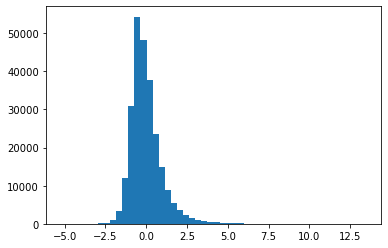

In [144]:
fig, ax = plt.subplots()
ax.hist(requests_21pro_g['w2v_0'], bins = 50)
plt.show()

In [145]:
requests_21pro_g.columns

Index(['service_request_parent_id', 'date_requested', 'case_age_days',
       'service_name', 'service_name_detail', 'park_name', 'case_origin',
       'public_description', 'is_weekend', 'day_0',
       ...
       'w2v_20', 'w2v_21', 'w2v_22', 'w2v_23', 'w2v_24', 'w2v_25', 'w2v_26',
       'w2v_27', 'w2v_28', 'w2v_29'],
      dtype='object', length=126)

In [146]:
X = requests_21pro_g[[
'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
'is_weekend',
'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
'in_park',
'cd_1.0', 'cd_2.0', 'cd_3.0',
'cd_4.0', 'cd_5.0', 'cd_6.0',
'cd_7.0', 'cd_8.0', 'cd_9.0', 
'is_phone',
'word_count',
'72 Hour Violation',
'COVID-19',
'Container Left Out',
'Container Out Late',
'Damaged/Knocked Over Pole',
'Dead Animal',
'Development Services - Code Enforcement',
'Drain Inlet',
'Encampment',
'Encroachment',
'Environmental Services Code Compliance',
'Fallen/Hanging Tree Limb',
'Flashing Traffic Signal Lights',
'Graffiti Removal',
'Graffiti Removal - Commercial',
'Illegal Dumping',
'Litter',
'Missed Collection',
'Other',
'Oversized Vehicle',
'Parking',
'Parking Zone Violation',
'Pavement Maintenance',
'Potential Missed Collection',
'Pothole',
'Quality of Life Issues',
'ROW Maintenance',
'Resurfacing Evaluation',
'Right-of-Way Code Enforcement',
'Shared Mobility Device',
'Sidewalk Repair Issue',
'Stormwater',
'Stormwater Code Enforcement',
'Stormwater Pollution Prevention',
'Street Flooded',
'Street Light Maintenance',
'Street Light Out of Service',
'Street Sweeping',
'Traffic Engineering',
'Traffic Sign Maintenance',
'Traffic Signal Issue',
'Traffic Signal Out of Service',
'Traffic Signal Timing',
'Trash/Recycling Collection',
'Tree Maintenance',
'Tree Removal',
'Tree Trimming for Pedestrian/Vehicle Clearance',
'Trimming Request',
'Vegetation Encroachment',
'Waste on Private Property',
'Weed Cleanup',
'w2v_0',
'w2v_1',
'w2v_2',
'w2v_3',
'w2v_4',
'w2v_5',
'w2v_6',
'w2v_7',
'w2v_8',
'w2v_9',
'w2v_10',
'w2v_11',
'w2v_12',
'w2v_13',
'w2v_14',
'w2v_15',
'w2v_16',
'w2v_17',
'w2v_18',
'w2v_19',
'w2v_20',
'w2v_21',
'w2v_22',
'w2v_23',
'w2v_24',
'w2v_25',
'w2v_26',
'w2v_27',
'w2v_28',
'w2v_29']]
y = requests_21pro_g['case_age_days']

In [147]:
print(X.columns)

Index(['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'is_weekend', 'month_1', 'month_2',
       ...
       'w2v_20', 'w2v_21', 'w2v_22', 'w2v_23', 'w2v_24', 'w2v_25', 'w2v_26',
       'w2v_27', 'w2v_28', 'w2v_29'],
      dtype='object', length=113)


In [148]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [149]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(201757, 113)
(50440, 113)
(201757,)
(50440,)


In [152]:
#Instantiate model
xg_reg = xgb.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                          colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, seed=27)

In [153]:
xg_reg.fit(X_train, y_train)

XGBoostError: [19:41:24] C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:148: label must be in [0,1] for logistic regression

In [ ]:
preds = xg_reg.predict(X_test)

In [ ]:
print(preds)

In [153]:
rmse = np.sqrt(mean_squared_error(y_test,preds))

print("RMSE: %f" % (rmse))

RMSE: 93.138948


In [154]:
r2 = r2_score(y_test, xg_reg.predict(X_test))
print(r2)

0.4787936285363461


In [155]:
pickle.dump(xg_reg, open('../data/simple_model_x.pkl', 'wb'))

In [156]:
with open('../data/simple_model_x.pkl', 'rb') as file:
    test_pickle = pickle.load(file)

In [157]:
pickle.dump(requests_21pro_g, open('../data/processed_21_data.pkl', 'wb'))

#### Try Parameter Grid Search to Improve the Results with XGBoost

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [159]:
kf = KFold(n_splits=2, shuffle=True, random_state=33)
params = {
        'min_child_weight': [1, 10],
        'gamma': [0.5, 1.5, 5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3,5]
        }
xg_reg_gridsearch = GridSearchCV(xg_reg, params, cv=kf)
xg_reg_gridsearch.fit(X_train, y_train)
print(xg_reg_gridsearch.best_params_, xg_reg_gridsearch.best_score_)

{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0} 0.4530872840786804


## 5. LDA Testing

### Imports

In [160]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mnicn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [161]:
import json
import glob

#gensim imports
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import ldamodel

# spacy imports
import spacy
from nltk.corpus import stopwords

In [162]:
#vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# from pyLDAvis import gensim


### Script to Hangle JSON Data

In [163]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        return (data)
    
def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

### Create Stopwords

In [164]:
stopwords = stopwords.words("english")

In [165]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [166]:
# data = load_data("data/ushmm_dn.json")["texts"]

# print(data)

### Define Lemmatization
This lemmatization function works on a list of tokens.

In [167]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [168]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"]) - this should be done within function but not working! in cell above. 
    texts_out = []
    for text in texts:
        #doc object (below) to contain essential metadata
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [169]:
test_text = ['My name is Melissa who are you good sir and do you have any bananas for me?']
test_doc = nlp('My name is Melissa who are you good sir and do you have any bananas for me?')
lemmatized_text = lemmatization(test_text)
print(lemmatized_text)

['name good sir banana']


In [170]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

In [171]:
data_words = gen_words(lemmatized_text)

In [172]:
id2word = corpora.Dictionary(data_words)

corpus =[]
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)
    
print (corpus[0][0:20])

[(0, 1), (1, 1), (2, 1), (3, 1)]


In [173]:
word = id2word[[0][:1][0]]
print(word)

banana


In [174]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=id2word, 
                                            num_topics=3, 
                                            random_state=100, 
                                            update_every=1, 
                                            chunksize=100,
                                            passes=10,
                                            alpha="auto")

In [175]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds')
vis



C:\Users\mnicn\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\mnicn\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=                  x             y  topics  cluster       Freq
topic                                                        
0     -4.111181e-09  4.028695e-09       1        1  96.975267
2      3.197425e-09 -3.083913e-09       2        1   1.513028
1      9.137553e-10 -9.447820e-10       3        1   1.511705, topic_info=     Term      Freq     Total Category  logprob  loglift
0  banana  0.000000  0.000000  Default   4.0000   4.0000
1    good  1.000000  1.000000  Default   3.0000   3.0000
3     sir  1.000000  1.000000  Default   2.0000   2.0000
2    name  1.000000  1.000000  Default   1.0000   1.0000
2    name  0.969827  1.000070   Topic1  -1.3862   0.0000
3     sir  0.969800  1.000044   Topic1  -1.3862   0.0000
1    good  0.969770  1.000016   Topic1  -1.3863   0.0000
0  banana  0.969613  0.999869   Topic1  -1.3864  -0.0000
0  banana  0.015136  0.999869   Topic2  -1.3859   0.0005
1    good  0.015130  1.000016   Topic2  -1.3863  -0.0001
2    name  0.015128  1.000070   Topic2  -1.3864  -0.0002
3     sir  0.015128  1.000044   Topic2  -1.3865  -0.0002
0  banana  0.015120  0.999869   Topic3  -1.3861   0.0003
1    good  0.015117  1.000016   Topic3  -1.3863  -0.0000
3     sir  0.015117  1.000044   Topic3  -1.3863  -0.0001
2    name  0.015115  1.000070   Topic3  -1.3865  -0.0002, token_table=      Topic      Freq    Term
term                         
0         1  1.000131  banana
1         1  0.999984    good
2         1  0.999930    name
3         1  0.999956     sir, R=4, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## 5. Tensorflow Testing

In [176]:
requests_21 = pd.read_csv('../data/2021_closed_requests.csv', low_memory=False)

In [177]:
requests_21.head()

,service_request_id,service_request_parent_id,sap_notification_number,date_requested,case_age_days,case_record_type,service_name,service_name_detail,date_closed,status,...,zipcode,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,referred,iamfloc,floc,public_description
0,100123,NaN,4.030000e+10,2016-08-17T16:40:00,1654.0,TSW,Pavement Maintenance,CONCRETE PAVEMENT REPAIR ISSUE,2021-02-26,Closed,...,NaN,5.0,31.0,Rancho Bernardo,NaN,Web,NaN,SS-020515-PV1,SS-020515,We have a cement street it is buckling and one...
1,100191,87204.0,NaN,2016-08-17T23:48:00,1842.0,TSW,Pavement Maintenance,Evaluate for Resurfacing/Slurry,2021-09-02,Closed,...,NaN,5.0,3.0,Carmel Mountain Ranch,NaN,Web,NaN,NaN,SS-022700,Potholes and uneven pavement throughout Rancho...
2,100194,NaN,4.030001e+10,2016-08-18T04:17:00,1652.0,TSW,Pavement Maintenance,DAMAGED CURB,2021-02-25,Closed,...,NaN,2.0,6.0,Clairemont Mesa,NaN,Web,NaN,SS-014744-PV1,SS-014744,"curb cracked, please fill\ngutter joint depres..."
3,100241,NaN,4.030001e+10,2016-08-18T09:23:00,1751.0,TSW,Stormwater,DRAIN INLET,2021-06-04,Closed,...,NaN,3.0,19.0,Mission Valley,NaN,Email,NaN,IN22626,43802117,BRUSH AND OTHER DEBRIS IN DRAIN - REQUEST REMOVAL
4,100867,NaN,4.030000e+10,2016-08-21T12:19:00,1838.0,TSW,Pavement Maintenance,EVALUATE FOR RESURFACING/SLURRY,2021-09-02,Closed,...,NaN,9.0,57.0,Mid-City:Eastern Area,NaN,Mobile,NaN,SS-026868-PV1,SS-026868,This road needs To be repaired immediately


In [178]:
with open('../data/categories_df.pkl', 'rb') as file:
        categories_df = pickle.load(file)

In [179]:
categories_df

,service_name,detailed_type
0,Pavement Maintenance,Pavement Maintenance
4,Pavement Maintenance,Resurfacing Evaluation
22,Sidewalk Repair Issue,Sidewalk Repair Issue
50,Stormwater,Drain Inlet
79,Stormwater,Stormwater
130,Pothole,Pothole
175,Street Sweeping,Street Sweeping
298,Street Flooded,Street Flooded
384,Tree Maintenance,Tree Trimming for Pedestrian/Vehicle Clearance
468,Tree Maintenance,Tree Removal


## 6. Building a Pipeline

### a. Picking Pipeline